<a href="https://colab.research.google.com/github/Israelchguevara/Python-/blob/main/Generaci%C3%B3n_de_Hostnames_Python_Avanzado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Generación de hostnames Programación Python (Avanzado)**

Este cuaderno reproduce  la práctica de **Python Avanzado** con explicaciones **paso a paso**:
1) Generación de *hostnames* con reglas y proporciones.
2) Construcción de un `DataFrame` de **Pandas**.
3) Exportación a **CSV** y validación de lectura.
4) Visualizaciones: gráfico *Country vs Enviroment* y figura **2×2**.

> Ejecuta las celdas en orden. Puedes usar `Runtime → Run all` en Colab.



## 1) Instalación e importación de librerías
Instalamos (si es necesario) y cargamos las librerías requeridas.


In [ ]:
# Si trabajas en Colab y te faltan librerías, descomenta:
# !pip install pandas matplotlib

%matplotlib inline

from __future__ import annotations

import random
from collections import defaultdict
from typing import List, Dict, Tuple

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

print(pd.__version__, ' | ', np.__version__)

2.2.2  |  2.0.2



## 2) Semilla (opcional)
Para reproducibilidad de resultados en las proporciones, podemos fijar una semilla.


In [ ]:
# reproducibilidad exacta
random.seed(42)
np.random.seed(42)


## 3) Mapas y proporciones
Definimos la codificación y las **probabilidades** de cada componente del *hostname*.


In [ ]:
# --- Sistemas Operativos ---
OS_MAP = {'L': 'Linux', 'S': 'Solaris', 'A': 'AIX', 'H': 'HP-UX'}
OS_P   = {'L': 0.40, 'S': 0.30, 'A': 0.20, 'H': 0.10}

# --- Entornos ---
ENV_MAP = {'D': 'Development', 'I': 'Integration', 'T': 'Testing', 'S': 'Staging', 'P': 'Production'}
ENV_P   = {'D': 0.10, 'I': 0.10, 'T': 0.25, 'S': 0.25, 'P': 0.30}

# --- Países ---
COUNTRY_MAP = {'NOR': 'Norway', 'FRA': 'France', 'ITA': 'Italy', 'ESP': 'Spain', 'DEU': 'Germany', 'IRL': 'Ireland'}
COUNTRY_P   = {'NOR': 0.06, 'FRA': 0.09, 'ITA': 0.16, 'ESP': 0.16, 'DEU': 0.23, 'IRL': 0.30}

print('Mapas y probabilidades definidos.')

Mapas y probabilidades definidos.



## 4) Funciones utilitarias de mapeo
Obtener **OS**, **enviroment** y **country** desde el *hostname*.


In [ ]:
def get_os(hostname: str) -> str:
    """Devuelve el SO según 1er carácter. Si no coincide, 'Unknow'."""
    if not hostname:
        return 'Unknow'
    return OS_MAP.get(hostname[0], 'Unknow')

def get_enviroment(hostname: str) -> str:
    """Devuelve el entorno según 2º carácter. Si no coincide, 'Unknow'."""
    if len(hostname) < 2:
        return 'Unknow'
    return ENV_MAP.get(hostname[1], 'Unknow')

def get_country(hostname: str) -> str:
    """Devuelve el país según posiciones 3–5. Si no coincide, 'Unknow'."""
    if len(hostname) < 5:
        return 'Unknow'
    return COUNTRY_MAP.get(hostname[2:5], 'Unknow')


## 5) Generación de *hostnames*
Creamos una elección ponderada y la función `set_hostnames(n)` para producir *hostnames* válidos.


In [ ]:
from typing import Iterable

def _weighted_choice(mapping: Dict[str, float]) -> str:
    keys = list(mapping.keys())
    probs = [mapping[k] for k in keys]
    return str(np.random.choice(keys, p=probs))

def set_hostnames(number_of_hosts: int) -> List[str]:
    """Genera N hostnames con formato:
    [OS][ENV][PAÍS(3)][NODO(3)]  (ej: LDIRL003)
    - NODO va de 001–999 por combinación (OS, ENV, COUNTRY).
    """
    hostnames: List[str] = []
    counters: Dict[Tuple[str, str, str], int] = defaultdict(int)

    for _ in range(number_of_hosts):
        os_code  = _weighted_choice(OS_P)
        env_code = _weighted_choice(ENV_P)
        c_code   = _weighted_choice(COUNTRY_P)

        key = (os_code, env_code, c_code)
        counters[key] += 1
        node_str = f"{counters[key]:03d}"

        hostname = f"{os_code}{env_code}{c_code}{node_str}"
        hostnames.append(hostname)

    return hostnames

# Prueba rápida
sample = set_hostnames(5)
sample

['LPIRL001', 'SIITA001', 'LPDEU001', 'ADIRL001', 'ATITA001']


## 6) Construcción del `DataFrame`
A partir de los *hostnames*, derivamos columnas: `hostname`, `os`, `enviroment`, `country`, `node`.


In [ ]:
def set_dataframe(count: int) -> pd.DataFrame:
    hostnames = set_hostnames(count)
    rows = []
    for h in hostnames:
        rows.append({
            'hostname': h,
            'os': get_os(h),
            'enviroment': get_enviroment(h),
            'country': get_country(h),
            'node': int(h[-3:]) if h[-3:].isdigit() else None
        })
    return pd.DataFrame(rows)

df = set_dataframe(1500)
df.head()

,hostname,os,enviroment,country,node
0,LTDEU001,Linux,Testing,Germany,1
1,STDEU001,Solaris,Testing,Germany,1
2,LTESP001,Linux,Testing,Spain,1
3,SPITA001,Solaris,Production,Italy,1
4,SSNOR001,Solaris,Staging,Norway,1



## 7) Exportar a CSV y validar lectura
Guardamos `df` en `data/hosts.csv` y lo volvemos a leer para comprobar.


In [ ]:
import os

def export_and_validate(df: pd.DataFrame, csv_path: str = 'data/hosts.csv') -> pd.DataFrame:
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
    df.to_csv(csv_path, index=False, header=True)
    return pd.read_csv(csv_path)

reloaded = export_and_validate(df)
(reloaded.shape, reloaded.head())

((1500, 5),
    hostname       os  enviroment  country  node
 0  LTDEU001    Linux     Testing  Germany     1
 1  STDEU001  Solaris     Testing  Germany     1
 2  LTESP001    Linux     Testing    Spain     1
 3  SPITA001  Solaris  Production    Italy     1
 4  SSNOR001  Solaris     Staging   Norway     1)


## 8) Gráfico: Country vs Enviroment
Agrupamos por `country` y `enviroment`, reorganizamos con `unstack` y graficamos.


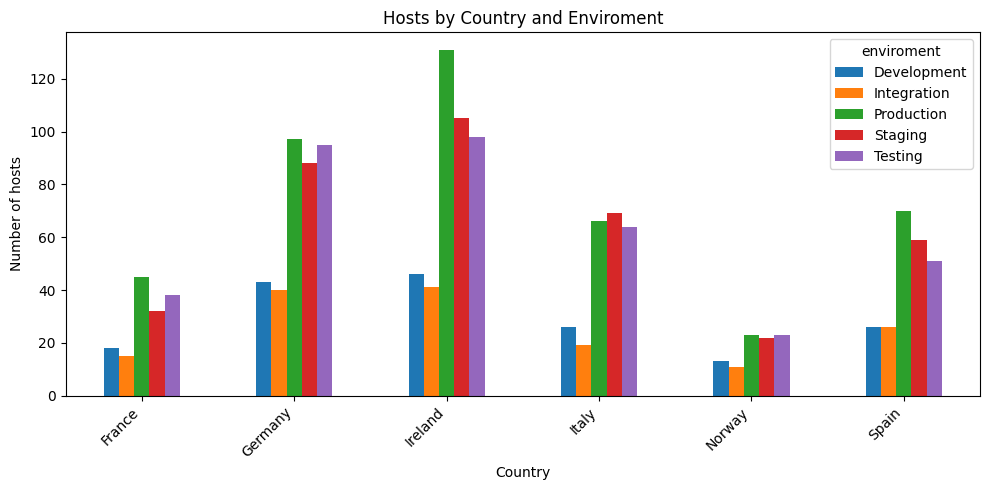

In [ ]:
grouped = df.groupby(['country','enviroment']).size().unstack(fill_value=0)
ax = grouped.plot(kind='bar', figsize=(10,5), title='Hosts by Country and Enviroment')
ax.set_xlabel('Country'); ax.set_ylabel('Number of hosts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 9) Figura 2×2 (subplots)
- **Sup. izquierda**: *Type of OS grouped by country* (barras horizontales).  
- **Sup. derecha**: *Total Operating Systems* (tarta) con número y %.  
- **Inf. izquierda**: *Total hosts by country* (barras horizontales) con anotaciones y `xlim`.  
- **Inf. derecha**: *Hosts by country grouped by enviroment* (barras).


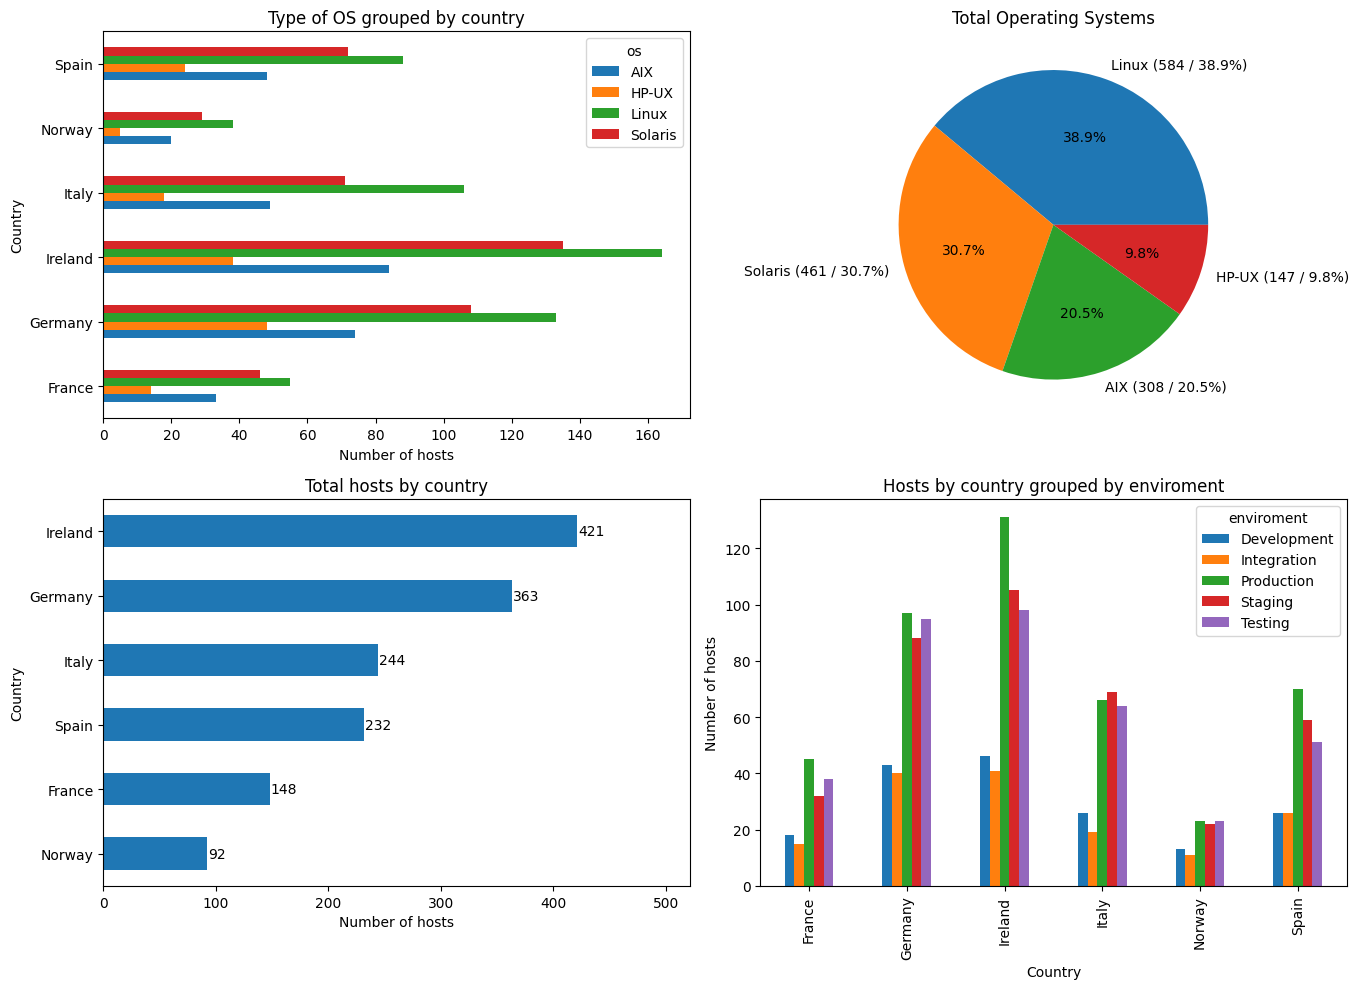

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14,10))

# (1) OS por país (barh)
os_by_country = df.groupby(['country','os']).size().unstack(fill_value=0)
os_by_country.plot(kind='barh', ax=axes[0,0], title='Type of OS grouped by country')
axes[0,0].set_xlabel('Number of hosts'); axes[0,0].set_ylabel('Country')

# (2) Total OS (pie) con conteo y %
os_counts = df['os'].value_counts()
total = os_counts.sum()
labels = [f"{name} ({count} / {count/total:.1%})" for name, count in os_counts.items()]
axes[0,1].pie(os_counts.values, labels=labels, autopct='%1.1f%%')
axes[0,1].set_title('Total Operating Systems')

# (3) Total hosts por país (barh) con anotaciones y xlim
country_counts = df['country'].value_counts().sort_values(ascending=True)
country_counts.plot(kind='barh', ax=axes[1,0], title='Total hosts by country')
axes[1,0].set_xlabel('Number of hosts'); axes[1,0].set_ylabel('Country')
for i, (country, count) in enumerate(country_counts.items()):
    axes[1,0].text(count + 1, i, str(count), va='center')
axes[1,0].set_xlim(0, country_counts.max() + 100)

# (4) Hosts por país agrupado por entorno (bar)
c_by_env = df.groupby(['country','enviroment']).size().unstack(fill_value=0)
c_by_env.plot(kind='bar', ax=axes[1,1], title='Hosts by country grouped by enviroment')
axes[1,1].set_xlabel('Country'); axes[1,1].set_ylabel('Number of hosts')

fig.tight_layout()
plt.show()